In [1092]:
#project_name = "."
#project_name = "jfreechart"
#project_name = "argouml"
project_name = "weka"

In [1093]:
import torch
import random

def load_pyg_dataset(file_path):
    return torch.load(file_path)

output_file_path = "output/" + project_name + "/pyg_dataset_for_god_component.pt"
dataset = load_pyg_dataset(output_file_path)

def add_train_mask_to_pyg_data(data, train_ratio=0.8):
    num_nodes = data.num_nodes
    num_train_nodes = int(train_ratio * num_nodes)

    # Generate a list of True and False values with the specified ratio
    mask_values = [True] * num_train_nodes + [False] * (num_nodes - num_train_nodes)

    # Randomly shuffle the mask values
    random.shuffle(mask_values)

    # Convert the mask_values list to a boolean tensor and assign it to the Data object
    data.train_mask = torch.tensor(mask_values, dtype=torch.bool)

def add_test_mask_to_pyg_data(data):
    # If the train_mask is not set, raise an exception
    if not hasattr(data, 'train_mask'):
        raise ValueError("Please add a train_mask to the Data object first.")
    
    # Create a test mask as the complement of the train mask
    data.test_mask = ~data.train_mask


add_train_mask_to_pyg_data(dataset, train_ratio=0.7)
add_test_mask_to_pyg_data(dataset)

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Data(x=[89, 10], edge_index=[2, 1633], y=[89], edge_weight=[1633], num_classes=2, train_mask=[89], test_mask=[89]):
Number of graphs: 7
Number of features: 10
Number of classes: 2

Data(x=[89, 10], edge_index=[2, 1633], y=[89], edge_weight=[1633], num_classes=2, train_mask=[89], test_mask=[89])
Number of nodes: 89
Number of edges: 1633
Average node degree: 18.35
Number of training nodes: 62
Training node label rate: 0.70
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [1094]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=10, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [1095]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 1001):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 127.0341
Epoch: 002, Loss: 92.4801
Epoch: 003, Loss: 71.2170
Epoch: 004, Loss: 100.2957
Epoch: 005, Loss: 63.8843
Epoch: 006, Loss: 95.0908
Epoch: 007, Loss: 58.2952
Epoch: 008, Loss: 41.4173
Epoch: 009, Loss: 37.1879
Epoch: 010, Loss: 26.7397
Epoch: 011, Loss: 16.0804
Epoch: 012, Loss: 19.9638
Epoch: 013, Loss: 15.3065
Epoch: 014, Loss: 15.0362
Epoch: 015, Loss: 8.8625
Epoch: 016, Loss: 10.0036
Epoch: 017, Loss: 6.6938
Epoch: 018, Loss: 3.8538
Epoch: 019, Loss: 4.8137
Epoch: 020, Loss: 7.0286
Epoch: 021, Loss: 9.0418
Epoch: 022, Loss: 6.0257
Epoch: 023, Loss: 5.4253
Epoch: 024, Loss: 5.0775
Epoch: 025, Loss: 5.3166
Epoch: 026, Loss: 7.4223
Epoch: 027, Loss: 4.8047
Epoch: 028, Loss: 3.6544
Epoch: 029, Loss: 6.0919
Epoch: 030, Loss: 6.0131
Epoch: 031, Loss: 6.8938
Epoch: 032, Loss: 7.7015
Epoch: 033, Loss: 5.3074
Epoch: 034, Loss: 5.2523
Epoch: 035, Loss: 3.3729
Epoch: 036, Loss: 2.6194
Epoch: 037, Loss: 2.2147
Epoch: 038, Loss: 1.3081
Epoch: 039, Loss: 2.1395
Epoch: 0

In [1096]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9259


In [1097]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_results(y_test, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

model.eval()
out = model(data.x)
pred = out.argmax(dim=1)
evaluate_results(data.y[data.test_mask], pred[data.test_mask])

Confusion Matrix:
[[21  0]
 [ 2  4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.67      0.80         6

    accuracy                           0.93        27
   macro avg       0.96      0.83      0.88        27
weighted avg       0.93      0.93      0.92        27



In [1098]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(10, 16)
  (conv2): GCNConv(16, 2)
)


In [1099]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index, data.edge_weight)

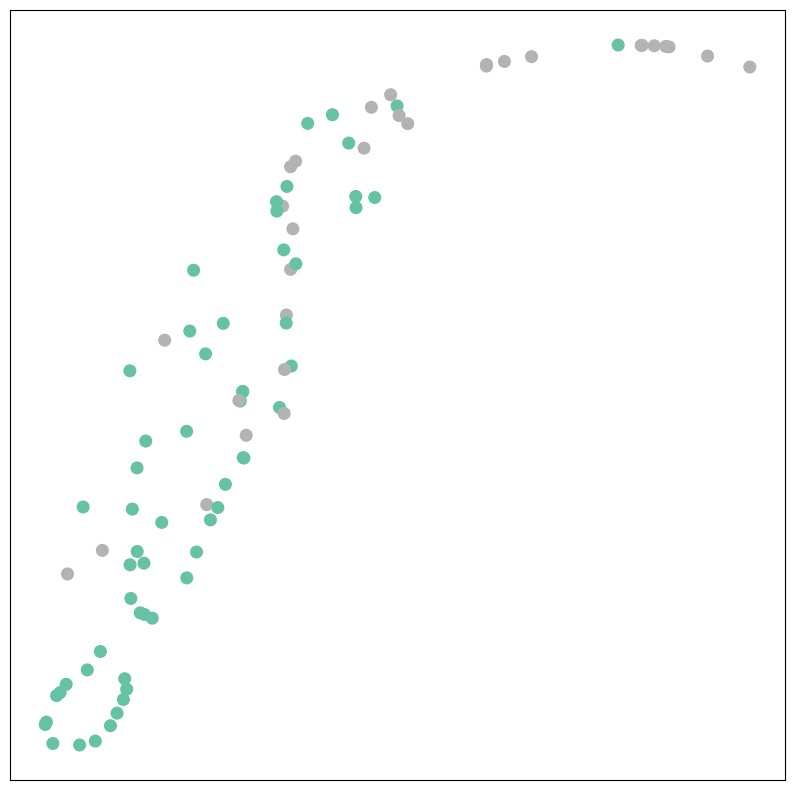

In [1100]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
visualize(out, color=data.y)

In [1101]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index, data.edge_weight)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 2001):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1411.3998
Epoch: 002, Loss: 912.4468
Epoch: 003, Loss: 638.5460
Epoch: 004, Loss: 1294.9830
Epoch: 005, Loss: 723.1570
Epoch: 006, Loss: 1410.0289
Epoch: 007, Loss: 969.9630
Epoch: 008, Loss: 539.7299
Epoch: 009, Loss: 636.6659
Epoch: 010, Loss: 799.3735
Epoch: 011, Loss: 682.6063
Epoch: 012, Loss: 887.8897
Epoch: 013, Loss: 1131.5568
Epoch: 014, Loss: 666.7394
Epoch: 015, Loss: 478.5068
Epoch: 016, Loss: 1284.8894
Epoch: 017, Loss: 703.9575
Epoch: 018, Loss: 595.7534
Epoch: 019, Loss: 1151.8074
Epoch: 020, Loss: 663.9496
Epoch: 021, Loss: 573.3288
Epoch: 022, Loss: 635.6681
Epoch: 023, Loss: 692.0690
Epoch: 024, Loss: 546.7798
Epoch: 025, Loss: 501.2793
Epoch: 026, Loss: 497.1920
Epoch: 027, Loss: 513.8864
Epoch: 028, Loss: 317.1344
Epoch: 029, Loss: 513.9701
Epoch: 030, Loss: 513.2874
Epoch: 031, Loss: 684.8458
Epoch: 032, Loss: 665.4908
Epoch: 033, Loss: 277.0977
Epoch: 034, Loss: 416.6086
Epoch: 035, Loss: 163.2896
Epoch: 036, Loss: 259.9796
Epoch: 037, Loss: 304.

In [1102]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8519


In [1103]:
model.eval()
out = model(data.x, data.edge_index, data.edge_weight)
pred = out.argmax(dim=1)
evaluate_results(data.y[data.test_mask], pred[data.test_mask])

Confusion Matrix:
[[20  1]
 [ 3  3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        21
           1       0.75      0.50      0.60         6

    accuracy                           0.85        27
   macro avg       0.81      0.73      0.75        27
weighted avg       0.84      0.85      0.84        27

